# End-to-End Pretraining Notebook

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import xarray as xr
import sys
import tensorflow as tf
from tensorflow import keras
from functools import partial

import os

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
import xgboost

sys.path.insert(0, '../../src')

from utils import df_to_xarray,read_xarray, custom_rmse

sys.path.insert(0, '../../src/preprocess')
from data_preprocess import preprocess_image_reduced,preprocess_images_nfp, inverse_scale_frame
from data_preprocess import preprocess_images, inverse_scale_image, preprocess_image_reduced

/burg/glab/users/jn2808/ocean_co2/env/lib/python3.8/site-packages/xarray/backends/cfgrib_.py:27: UserWarning: Failed to load cfgrib - most likely there is a problem accessing the ecCodes library. Try `import cfgrib` to get the full error message
  warnings.warn(
2024-07-16 21:17:58.058253: W tensorflow/stream_executor/platform/default/dso_loader.cc:60] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /cm/shared/apps/slurm/current/lib64/slurm:/cm/shared/apps/slurm/current/lib64
2024-07-16 21:17:58.058273: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


## Data Loading and Preprocessing

In [2]:
## loading data
def pco2_socat_preprocess(arr):
    nans=np.isnan(arr)
    min_val=arr[~nans].min()
    arr[nans]=min_val
    return arr


dist_map = pd.read_csv("../../src/dist_map.csv",header=None).to_numpy()
dist_map = np.roll(np.fliplr(dist_map),180)
dist_map = np.repeat(dist_map[np.newaxis, :, : ], 421, axis=0)


# Reading Data
dir = "../../data/"
dir_name = "../../data/member_001"
data_nums = ["001", "002", "009", "010", "011", "012", "013", "014", "015", "016", "017", "018", "020",
             "021", "023", "024", "025", "030", "031", "034", "035", "101", "102", "103", "104"]

X_all = np.empty((0, 180, 360, 5))
y_all = np.empty((0, 180, 360))

for i in range(5):
    dir_name = dir + "member_" + str(data_nums[i])
    chl,mld,sss,sst,u10,xco2,icefrac,patm,pco2 = read_xarray(dir_name,num =data_nums[i])
    
    chl_images = preprocess_image_reduced(chl.Chl.data)
    sss_images = preprocess_image_reduced(sss.SSS.data)
    sst_images = preprocess_image_reduced(sst.SST.data)
    mld_images = preprocess_image_reduced(mld.MLD.data)
    xco2_images = preprocess_image_reduced(xco2.XCO2.data,xco2=True)
    y1 =  preprocess_image_reduced(pco2.pCO2.data)
    dist_map = preprocess_image_reduced(dist_map)
    X1 = np.dstack((chl_images, dist_map, sss_images, sst_images, xco2_images))
    #X1 = np.dstack((chl_images, mld_images, sss_images, sst_images, xco2_images))
    X1 = X1.reshape((421,180,360,5),order='F')
    
    X1 = X1[:420]
    y1 = y1[:420]
    
    X_all = np.concatenate((X_all, X1))
    y_all = np.concatenate((y_all, y1))


/burg/glab/users/jn2808/ocean_co2/env/lib/python3.8/site-packages/xarray/backends/plugins.py:61: RuntimeWarning: Engine 'cfgrib' loading failed:
Cannot find the ecCodes library
  warnings.warn(f"Engine {name!r} loading failed:\n{ex}", RuntimeWarning)


In [3]:
X_all.shape, y_all.shape

((2100, 180, 360, 5), (2100, 180, 360))

In [4]:
frame = 1
X_all_conv = np.empty((0, frame, 180, 360, 5))
y_all_conv = np.empty((0, frame, 180, 360, 1))
X_index=np.lib.stride_tricks.sliding_window_view(range(421),frame)

tmp = 1

for i in range(5):
    dir_name = dir + "member_" + str(data_nums[i])
    chl,mld,sss,sst,u10,xco2,icefrac,patm,pco2 = read_xarray(dir_name,num=data_nums[i])

    chl_images = preprocess_image_reduced(chl.Chl.data)
    sss_images = preprocess_image_reduced(sss.SSS.data)
    sst_images = preprocess_image_reduced(sst.SST.data)
    xco2_images = preprocess_image_reduced(xco2.XCO2.data,xco2=True)
    pco2 = preprocess_image_reduced(pco2.pCO2.data)
    dist_map = preprocess_image_reduced(dist_map)
    
    y = np.expand_dims(pco2[X_index][1:], axis=4)
    
    X = np.dstack((chl_images, dist_map, sss_images, sst_images, xco2_images))
    tmp+=1
    X = X.reshape((421,180,360,5),order='F')
    X = X[X_index][:-1]
    
    X_all_conv = np.concatenate((X_all_conv, X))
    y_all_conv = np.concatenate((y_all_conv, y))


shuffle_ind = (np.arange(X_all_conv.shape[0]))
np.random.shuffle(shuffle_ind)
X_all_conv = np.array(X_all_conv)[shuffle_ind.astype(int)]
y_all_conv = np.array(y_all_conv)[shuffle_ind.astype(int)]

X_all_conv.shape, y_all_conv.shape

((2090, 3, 180, 360, 5), (2090, 3, 180, 360, 1))

In [5]:

INPUT_SHAPE1=X_all[0].shape
OUTPUT_SHAPE1=y_all[0].shape

OUTPUT_SHAPE2=y_all_conv[0].shape

tmp_shape = (1,180, 360, 1)
INPUT_SHAPE2 = (1,180,360,5)

INPUT_SHAPE1, OUTPUT_SHAPE1, OUTPUT_SHAPE2

((180, 360, 5), (180, 360), (3, 180, 360, 1))

## Model

In [6]:
DefaultConv2D = partial(keras.layers.Conv2D,
                        kernel_size=5,activation='elu',
                        padding="SAME")

DefaultConvLSTM2D = partial(keras.layers.ConvLSTM2D,
                        filters=32, kernel_size=(5, 5),
                        padding="same",return_sequences=True,
                        activation="elu",)


# define input layers
unet_input = keras.layers.Input(INPUT_SHAPE1)
convlstm_input = keras.layers.Input(INPUT_SHAPE2)

# unet
u1 = DefaultConv2D(filters=32)(unet_input)
u1 = DefaultConv2D(filters=32)(u1)
pool1 = keras.layers.MaxPooling2D(pool_size=3)(u1)
pool1 = keras.layers.Dropout(0.2)(pool1)

u2 = DefaultConv2D(filters=64)(pool1)
u2 = DefaultConv2D(filters=64)(u2)
pool2 = keras.layers.MaxPooling2D(pool_size=3)(u2)
pool2 = keras.layers.Dropout(0.2)(pool2)

u3 = DefaultConv2D(filters=128)(pool2)
u3 = DefaultConv2D(filters=128)(u3)

u2 = keras.layers.UpSampling2D(size=3)(u3)
u2 = DefaultConv2D(filters=64)(u2)
u2 = DefaultConv2D(filters=64)(u2)
u2 = keras.layers.Dropout(0.2)(u2)

u1 = keras.layers.UpSampling2D(size=3)(u2)
u1 = DefaultConv2D(filters=32)(u1)
u1 = DefaultConv2D(filters=4)(u1)
u1 = DefaultConv2D(filters=1,kernel_size=1)(u1)
output1 = keras.layers.Reshape(OUTPUT_SHAPE1)(u1)

#concatenate unet_convlstm
p = keras.layers.Reshape(tmp_shape)(u1)
final_input = tf.keras.layers.Concatenate(axis=-1)([convlstm_input,p])

#convlstm
c1 = DefaultConvLSTM2D()(final_input)
c1 = keras.layers.BatchNormalization()(c1)

c2 = DefaultConvLSTM2D(kernel_size=(5,5))(c1)
c2 = keras.layers.BatchNormalization()(c2)

c3 = DefaultConvLSTM2D(kernel_size=(3,3))(c2)
c3 = keras.layers.BatchNormalization()(c3)

c4 = DefaultConvLSTM2D(kernel_size=(1,1))(c3)
output2 = keras.layers.Conv3D(filters = 1, kernel_size=(3,3,3),
                         activation="elu", padding="same")(c4)

2024-07-16 21:19:41.528543: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2024-07-16 21:19:41.616063: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2024-07-16 21:19:41.764505: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:3b:00.0 name: Quadro RTX 8000 computeCapability: 7.5
coreClock: 1.62GHz coreCount: 72 deviceMemorySize: 44.48GiB deviceMemoryBandwidth: 581.23GiB/s
2024-07-16 21:19:41.764620: W tensorflow/stream_executor/platform/default/dso_loader.cc:60] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /cm/shared/apps/slurm/current/lib64/slurm:/cm/shared/apps/slurm/current/lib64
2024-07-16 21:19:41.765462: W tensorflow/stream_executor/platform/default/dso_loader.cc:60] Could not load dynamic l

In [7]:
model = keras.Model([unet_input,convlstm_input], [output1, output2])

In [8]:
model.compile(
    loss=[custom_rmse,custom_rmse], optimizer=keras.optimizers.Adam(
        learning_rate=0.001,
        beta_1=0.9,
        beta_2=0.99),)

In [9]:
model_path="../../models/pretrain_final.h5"

In [10]:
# Training...

# early_stopings = tf.keras.callbacks.EarlyStopping(monitor='conv3d_2_loss', min_delta=0, patience=6, verbose=1, mode='min')
# checkpoint =  tf.keras.callbacks.ModelCheckpoint(model_path, monitor='conv3d_2_loss', save_best_only=True, mode='min', verbose=0)
# callbacks=[early_stopings,checkpoint]

# epochs = 100
# batch_size = 16


# hist = model.fit(
#     [X_all,X_all_conv],
#     [y_all,y_all_conv],
#     batch_size=batch_size,
#     epochs=epochs,
#     callbacks=callbacks
# )

### Result

In [ ]:
def inverse_scale_image_nfp(arr, df):
    """
    inverse_scale_image(arr, df):
    - inverses the pco2 scaling
    """
    
    old_min = np.nanmin(df)
    old_max = np.nanmax(df)

    y_pred = arr*(old_max-old_min)/255+old_min
    
    tmp=np.nan_to_num(df[X_index][1:])
    y_true=np.expand_dims(tmp,axis=4)
    y_pred[y_true==0]=0
    return y_true,y_pred

In [12]:
dir_name = "../../data/member_102"
chl,mld,sss,sst,u10,xco2,icefrac,patm,pco2 = read_xarray(
    dir_name,num=102)
tmp = np.nan_to_num(pco2.pCO2.data[X_index][1:])

y_true_full = np.expand_dims(tmp,axis=4)
print(y_true_full.shape)
coord = (y_true_full==0.0)

(420, 1, 180, 360, 1)


In [13]:
chl_images = preprocess_image_reduced(chl.Chl.data)
sss_images = preprocess_image_reduced(sss.SSS.data)
sst_images = preprocess_image_reduced(sst.SST.data)
mld_images = preprocess_image_reduced(mld.MLD.data)
xco2_images = preprocess_image_reduced(xco2.XCO2.data,xco2=True)
y1 = preprocess_image_reduced(pco2.pCO2.data)
dist_map = preprocess_image_reduced(dist_map)
X1 = np.dstack((chl_images, dist_map, sss_images, sst_images, xco2_images))
X1 = X1.reshape((421,180,360,5),order='F')
X2 = X1[X_index][:-1]

X1 = X1[:420]
X1.shape,X2.shape

((420, 180, 360, 5), (420, 1, 180, 360, 5))

In [14]:
tf_model = tf.keras.models.load_model(model_path, custom_objects={'custom_rmse':custom_rmse})

predicted_image, predicted_frames= tf_model.predict([X1,X2],verbose=1)
predicted_image.shape,predicted_frames.shape

2024-07-10 20:58:09.070819: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2024-07-10 20:58:09.298374: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 2900000000 Hz


14/14 [==============================] - 69s 5s/step


((420, 180, 360), (420, 1, 180, 360, 1))

In [15]:
y_true_image = np.nan_to_num(pco2.pCO2.data)

print(y_true_image.shape)
coord2 = (y_true_image==pco2.pCO2.data.min())
coord2=coord2[:420]
predicted_image[coord2] = 0
y_true_unet,y_pred_unet = inverse_scale_image(predicted_image,pco2.pCO2.data[:420])

(421, 180, 360)


In [16]:
print("Full RMSE score:")
a=custom_rmse(y_true_unet,y_pred_unet)
print(a)

Full RMSE score:
tf.Tensor(9.013846, shape=(), dtype=float32)


In [17]:
y_true_unet[coord2] = np.nan
y_pred_unet[coord2] = np.nan
res_unet = y_true_unet - y_pred_unet

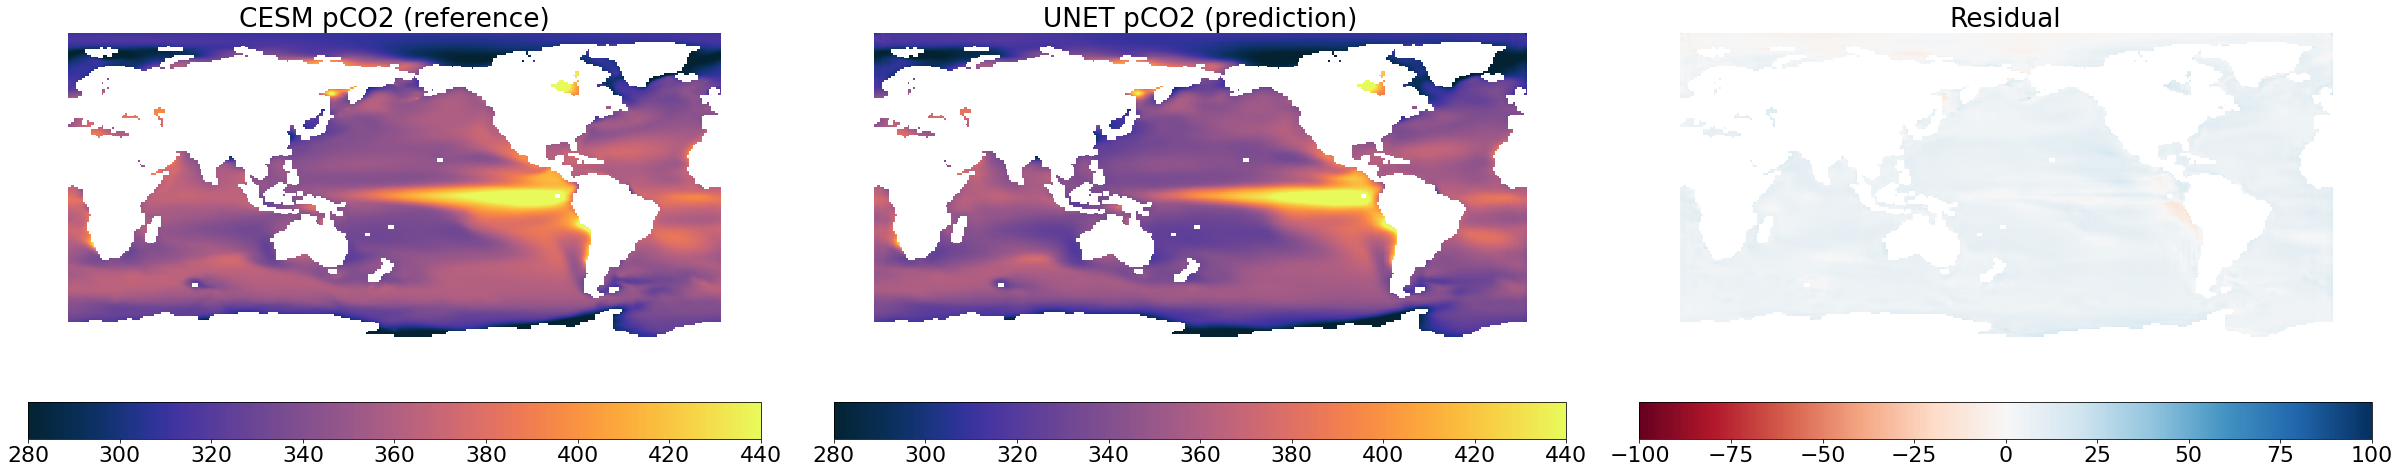

In [18]:
# CNN average Image
import cmocean as cm
import matplotlib.colors as mcolors
from mpl_toolkits.axes_grid1 import make_axes_locatable

figure, axis = plt.subplots(1, 3,figsize=(42, 8))

plt.rcParams.update({'font.size': 22})
norm = mcolors.Normalize(vmin=280, vmax = 440)
norm2 = mcolors.TwoSlopeNorm(vmin=-100, vmax = 100, vcenter=0)

avg_y_true = np.mean(y_true_unet,axis=0)
avg_y_pred = np.mean(y_pred_unet,axis=0)
avg_res = np.mean(res_unet,axis=0)

im0 = axis[0].imshow(np.flipud(avg_y_true[-168:]),cmap = cm.cm.thermal,norm=norm)
cbar0 = figure.colorbar(im0, ax=axis[0], orientation='horizontal')
axis[0].set_title("CESM pCO2 (reference)")
axis[0].axis('off')

# divider = make_axes_locatable(axis[0])
# cax = divider.append_axes('right', size='2%', pad=0.15)
# cbar=figure.colorbar(im0, cax=cax, orientation='vertical')
# cbar.ax.get_yaxis().labelpad = 20
# cbar.ax.set_ylabel('pCO2', rotation=270)
# cbar.set_ticklabels(np.arange(280,440,20))


im1 =axis[1].imshow(np.flipud(avg_y_pred[-168:]),cmap = cm.cm.thermal,norm=norm)
cbar1 = figure.colorbar(im1, ax=axis[1], orientation='horizontal')
axis[1].set_title("UNET pCO2 (prediction)")
axis[1].axis('off')

# divider = make_axes_locatable(axis[1])
# cax = divider.append_axes('right', size='2%', pad=0.15)
# cbar2=figure.colorbar(im1, cax=cax, orientation='vertical')
# cbar2.ax.get_yaxis().labelpad = 20
# cbar2.ax.set_ylabel('pred', rotation=270)
# cbar2.set_ticklabels(np.arange(280,440,20))


im2=axis[2].imshow(np.flipud(avg_res[-168:]),cmap = "RdBu",norm=norm2)
cbar2 = figure.colorbar(im2, ax=axis[2], orientation='horizontal')
axis[2].set_title("Residual")
axis[2].axis('off')

# divider = make_axes_locatable(axis[2])
# cax = divider.append_axes('right', size='2%', pad=0.15)
# cbar3=figure.colorbar(im2, cax=cax, orientation='vertical')
# cbar3.ax.get_yaxis().labelpad = 20
# cbar3.ax.set_ylabel('residual', rotation=270)
# cbar3.set_ticklabels(np.arange(-100,100,20))

plt.subplots_adjust(wspace=0.1)
# figure.suptitle("Average CESM Pre-training pCO2 | Prediction | Residual - over 1987/02-2017/01")
# plt.savefig("../../assets/figure5.1_unet.jpg", dpi=200)

In [19]:
predicted_frames[coord] = 0

y_true,y_pred=inverse_scale_image_nfp(predicted_frames,pco2.pCO2.data)  

print("Full RMSE score:")
a=custom_rmse(y_true,y_pred)
print(a)

Full RMSE score:
tf.Tensor(13.878262, shape=(), dtype=float32)


In [20]:
res = y_true-y_pred

y_true[coord]=np.nan
y_pred[coord]=np.nan

avg_y_true = np.mean(y_true,axis=0)
avg_y_pred = np.mean(y_pred,axis=0)
avg_res = np.mean(res,axis=0)



In [21]:
avg_y_true.shape

(1, 180, 360, 1)

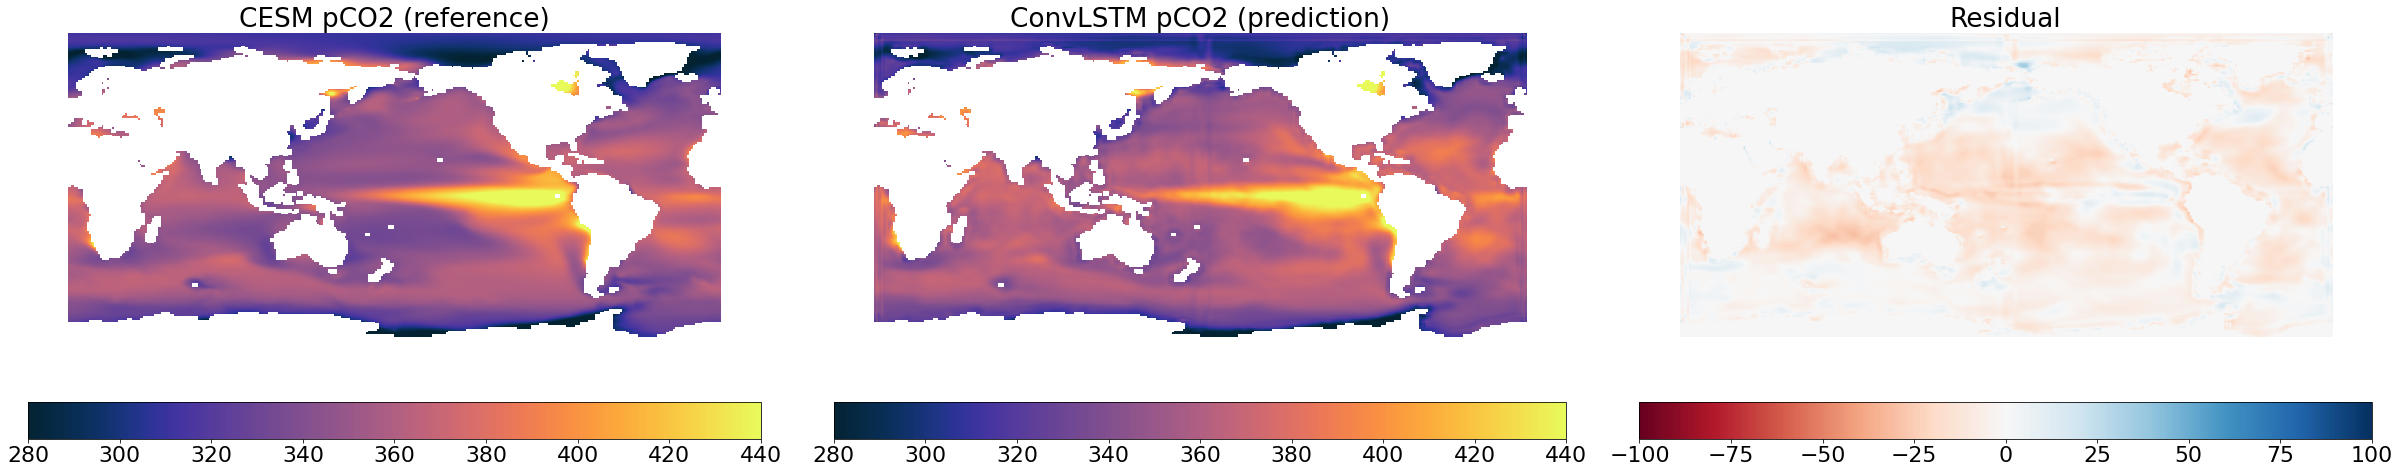

In [22]:
# ConvLSTM average Image
import cmocean as cm
import matplotlib.colors as mcolors
from mpl_toolkits.axes_grid1 import make_axes_locatable

figure, axis = plt.subplots(1, 3,figsize=(42, 8))

plt.rcParams.update({'font.size': 22})
norm = mcolors.Normalize(vmin=280, vmax = 440)
norm2 = mcolors.TwoSlopeNorm(vmin=-100, vmax = 100, vcenter=0)

im0 = axis[0].imshow(np.flipud(avg_y_true[0,-168:]),cmap = cm.cm.thermal,norm=norm)
cbar0 = figure.colorbar(im0, ax=axis[0], orientation='horizontal')
axis[0].set_title("CESM pCO2 (reference)")
axis[0].axis('off')

# divider = make_axes_locatable(axis[0])
# cax = divider.append_axes('right', size='2%', pad=0.15)
# cbar=figure.colorbar(im0, cax=cax, orientation='vertical')
# cbar.ax.get_yaxis().labelpad = 20
# cbar.ax.set_ylabel('pCO2', rotation=270)
# cbar.set_ticklabels(np.arange(280,440,20))


im1 =axis[1].imshow(np.flipud(avg_y_pred[0,-168:]),cmap = cm.cm.thermal,norm=norm)
cbar1 = figure.colorbar(im1, ax=axis[1], orientation='horizontal')
axis[1].set_title("ConvLSTM pCO2 (prediction)")
axis[1].axis('off')

# divider = make_axes_locatable(axis[1])
# cax = divider.append_axes('right', size='2%', pad=0.15)
# cbar2=figure.colorbar(im1, cax=cax, orientation='vertical')
# cbar2.ax.get_yaxis().labelpad = 20
# cbar2.ax.set_ylabel('pred', rotation=270)
# cbar2.set_ticklabels(np.arange(280,440,20))


im2=axis[2].imshow(np.flipud(avg_res[0,-168:]),cmap = "RdBu",norm=norm2)
cbar2 = figure.colorbar(im2, ax=axis[2], orientation='horizontal')
axis[2].set_title("Residual")
axis[2].axis('off')

# divider = make_axes_locatable(axis[2])
# cax = divider.append_axes('right', size='5%', pad=0.3)
# cbar3=figure.colorbar(im2, cax=cax, orientation='vertical')
# cbar3.ax.get_yaxis().labelpad = 20
# cbar3.ax.set_ylabel('residual', rotation=270)
# cbar3.set_ticklabels(np.arange(-100,100,20))

plt.subplots_adjust(wspace=0.1)
# figure.suptitle("Average CONVLSTM CESM Pre-training pCO2 | Prediction | Residual - over 1987/02-2017/01")
# plt.savefig("../../assets/figure5.2_convlstm.jpg", dpi=200)